In [1]:
!uv sync

Using CPython 3.13.1 interpreter at: C:\Users\Диана\AppData\Local\Programs\Python\Python313\python.exe
Creating virtual environment at: c:\Users\Диана\Documents\GitHub\BigData-project\.venv
Resolved 139 packages in 8ms
 Downloaded pywinpty
 Downloaded shapely
 Downloaded pygments
 Downloaded cramjam
 Downloaded widgetsnbextension
 Downloaded fonttools
 Downloaded pillow
 Downloaded setuptools
 Downloaded debugpy
 Downloaded pyproj
 Downloaded pywin32
 Downloaded matplotlib
 Downloaded jupyterlab
 Downloaded numpy
 Downloaded babel
 Downloaded notebook
 Downloaded pandas
 Downloaded pyogrio
 Downloaded jedi
 Downloaded rasterio
 Downloaded pyarrow
   Building pyspark==3.5.4
      Built pyspark==3.5.4
Prepared 122 packages in 5m 19s
Installed 135 packages in 11.51s
 + affine==2.4.0
 + anyio==4.8.0
 + argon2-cffi==23.1.0
 + argon2-cffi-bindings==21.2.0
 + arrow==1.3.0
 + asttokens==3.0.0
 + async-lru==2.0.4
 + attrs==25.1.0
 + babel==2.17.0
 + beautifulsoup4==4.13.3
 + bleach==6.2.0
 + br

In [5]:
from time import time
import math
import h3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tabulate import tabulate
import seaborn as sns

In [9]:
def test_speed_loading(path, trials=10):
    best_engine = 'pyarrow'
    best_mean = math.inf
    print("Path: ", path)
    for engine in ['pyarrow', 'fastparquet']:
        start_time = time()
        avg_time = []
        for i in range(trials):
            df = pd.read_parquet(path, engine=engine)
            second_time = time() 
            avg_time.append(second_time - start_time)
            start_time = second_time
        mean = sum(avg_time)/len(avg_time)
        print("Engine: ", engine, "Mean: ", mean, "std: ", math.sqrt(sum([i**2 for i in avg_time])/len(avg_time) - mean**2))
        if best_mean > mean:
            best_mean, best_engine = mean, engine
    print("Best engine: ", best_engine, "with mean: ", best_mean)
    return best_engine

In [26]:
summary_shape = 0
try:
    path = './data/transactions.parquet'
    # best_engine = test_speed_loading(path)
    best_engine = 'pyarrow'
    transactions = pd.read_parquet(path, engine=best_engine)
    transactions.name = 'transactions'
    transactions[['lat', 'lon']] = transactions['h3_09'].apply(h3.cell_to_latlng).to_list()
    print("Transactions shape: ", transactions.shape)
    summary_shape += transactions.shape[0]

    path = './data/moscow.parquet'
    # best_engine = test_speed_loading(path)
    best_engine = 'pyarrow'
    moscow = pd.read_parquet(path, engine=best_engine)
    moscow.name = 'moscow'
    moscow = moscow[moscow['tags'].notna()]
    print("Moscow shape: ", moscow.shape)
    summary_shape += moscow.shape[0]

    path = './data/target.parquet'
    # best_engine = test_speed_loading(path, 100)
    best_engine = 'fastparquet'
    target = pd.read_parquet(path, engine=best_engine)
    target.name = 'target'
    target[['lat', 'lon']] = target['h3_09'].apply(h3.cell_to_latlng).to_list()
    print("Target shape: ", target.shape)
    summary_shape += target.shape[0]
except FileNotFoundError:
    print("Error: File transactions.parquet wasn't found.  Put the proper path.")

Transactions shape:  (4151096, 13)
Moscow shape:  (571107, 4)
Target shape:  (157806, 4)


In [24]:
%cd ..

c:\Users\Диана\Documents\GitHub\BigData-project


C:\Users\Диана\AppData\Roaming\Python\Python313\site-packages\IPython\core\magics\osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [27]:
def open_lst(path):
    with open(path, "r") as f:
        df = pd.DataFrame({'h3_09': [x.strip() for x in f.readlines()]})
        df[['lat', 'lon']] = df['h3_09'].apply(h3.cell_to_latlng).to_list()
    return df

hexses_data = open_lst('./data/hexses_data.lst')
hexses_data.name = 'hexses_data'
print("hexses_data shape: ", hexses_data.shape)
summary_shape += hexses_data.shape[0]
hexses_target = open_lst('./data/hexses_target.lst')
hexses_target.name = 'hexses_target'
print("hexses_target shape: ", hexses_target.shape)
summary_shape += hexses_target.shape[0]
print("Summary shape: ", summary_shape)

hexses_data shape:  (8154, 3)
hexses_target shape:  (1657, 3)
Summary shape:  4889820


In [28]:
def dataframe_info_tabular(df, top_n=3):
    """Расширенный вывод информации о DataFrame."""

    print("\n--- DataFrame Shape ---")
    print(f"Rows: {df.shape[0]}, Columns: {df.shape[1]}")

    print("\n--- DataFrame Describe (Extended, Transposed) ---")

    def describe_and_aggregate(df_):
        desc = df_.describe(include='all').T
        desc.name = df_.name
        desc.insert(0, "Dtype", desc.index.map(df_.dtypes))
        desc.insert(1, "Unique", desc.index.map(df_.nunique()))

        top_freq = {}
        bottom_freq = {}
        for col_name in df_.columns:
            counts = df_[col_name].value_counts(dropna=False)
            top_freq[col_name] = {str(key): int(value) for key, value in counts.head(top_n).items()}
            bottom_freq[col_name] = {str(key): int(value) for key, value in counts.tail(top_n).items()}

        desc["Top Freq (value: count)"] = desc.index.map(top_freq)
        desc["Bottom Freq (value: count)"] = desc.index.map(bottom_freq)


        return desc.fillna('')

    combined_describe_df = describe_and_aggregate(df)

    # Замена 50% на медиану для object (и category)
    for col in combined_describe_df.index:
        if combined_describe_df.loc[col, 'Dtype'] == object or str(combined_describe_df.loc[col, 'Dtype']) == 'category':
            try:
                # Пытаемся вычислить медиану
                median_val = df[col].mode()[0]  # .mode() возвращает Series, берем первый элемент
                combined_describe_df.loc[col, '50%'] = median_val
            except (KeyError, IndexError):
                # Если столбца нет (KeyError) или mode() вернул пустой Series (IndexError)
                combined_describe_df.loc[col, '50%'] = '' #  или, например, 'N/A'
            except TypeError:
                #  Для datetime, например, mode() может вызвать TypeError
                combined_describe_df.loc[col, '50%'] = ''


    if 'unique' in combined_describe_df.columns:
        combined_describe_df = combined_describe_df.drop(columns=['unique'])

    desired_cols = ["Dtype", "Unique", "count", "mean", "std", "min", "25%", "50%", "75%", "max", "Top Freq (value: count)", "Bottom Freq (value: count)"]
    existing_cols = [col for col in desired_cols if col in combined_describe_df.columns]
    combined_describe_df = combined_describe_df[existing_cols]


    for col in combined_describe_df.select_dtypes(include=np.number):
        combined_describe_df[col] = combined_describe_df[col].apply(
            lambda x: f"{x:.4f}" if isinstance(x, float) else f"{x:,}"
        )

    return combined_describe_df.sort_values(by='Dtype')



dataframe_info_tabular(transactions)


--- DataFrame Shape ---
Rows: 4151096, Columns: 13

--- DataFrame Describe (Extended, Transposed) ---


C:\Users\Диана\AppData\Local\Temp\ipykernel_3972\1442484486.py:26: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  return desc.fillna('')


,Dtype,Unique,count,mean,std,min,25%,50%,75%,max,Top Freq (value: count),Bottom Freq (value: count)
customer_id,int64,"69,337",4151096.0000,46740.248076,27490.692232,1.0,22992.0,46038.0,69962.0,98450.0,"{'78329': 107, '39331': 107, '36107': 107}","{'75068': 20, '97127': 20, '79961': 18}"
datetime_id,int64,4,4151096.0000,2.100576,0.846003,0.0,2.0,2.0,3.0,3.0,"{'3': 1579903, '2': 1544148, '1': 891688}","{'2': 1544148, '1': 891688, '0': 135357}"
count,int64,226,4151096.0000,3.238023,6.292843,1.0,1.0,1.0,3.0,415.0,"{'1': 2399551, '2': 663146, '3': 299231}","{'183': 1, '260': 1, '253': 1}"
count_distinct,int64,82,4151096.0000,1.736469,2.391839,0.0,1.0,1.0,2.0,122.0,"{'1': 3027881, '2': 585070, '3': 214437}","{'68': 1, '106': 1, '89': 1}"
mcc_code,int64,24,4151096.0000,9.640391,4.07531,0.0,8.0,9.0,13.0,23.0,"{'13': 1512867, '8': 912094, '5': 422039}","{'21': 2917, '23': 1257, '19': 1116}"
sum,float64,"571,331",4151096.0000,2633.186039,18580.131901,0.01,278.99,755.0,2200.0,21955000.0,"{'300.0': 40656, '100.0': 39025, '200.0': 32292}","{'9630.55': 1, '0.38': 1, '19354.0': 1}"
avg,float64,"761,924",4151096.0000,1290.334265,10566.348232,0.01,183.333333,400.0,980.0,10977500.0,"{'56.0': 57532, '100.0': 45634, '300.0': 41064}","{'231.96333333': 1, '895.14': 1, '914.23714286..."
min,float64,"240,151",4151096.0000,1087.152085,8965.371496,0.01,105.0,269.97,737.6525,9001900.0,"{'56.0': 72378, '100.0': 67786, '300.0': 50865}","{'2418.47': 1, '1356.75': 1, '1031.39': 1}"
max,float64,"350,464",4151096.0000,1579.648991,14216.511618,0.01,210.0,500.0,1288.0,15405000.0,"{'56.0': 67232, '300.0': 51187, '100.0': 50821}","{'2215.67': 1, '2868.39': 1, '62355.47': 1}"
std,float64,"1,010,251",1751545.0000,591.17163,8948.862525,0.0,56.568542,174.513954,450.1701,6261430.547407,"{'nan': 2399551, '0.0': 159784, '70.7106781186...","{'152.87698889412144': 1, '298.92076965867284'..."


In [29]:
dataframe_info_tabular(target)


--- DataFrame Shape ---
Rows: 157806, Columns: 4

--- DataFrame Describe (Extended, Transposed) ---


C:\Users\Диана\AppData\Local\Temp\ipykernel_3972\1442484486.py:26: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  return desc.fillna('')


,Dtype,Unique,count,mean,std,min,25%,50%,75%,max,Top Freq (value: count),Bottom Freq (value: count)
customer_id,int64,"69,337",157806.0000,47693.492041,27753.50098,1.0,23730.25,47273.0,71422.5,98450.0,"{'20772': 54, '22639': 27, '75977': 24}","{'63522': 1, '65235': 1, '1607': 1}"
lat,float64,"1,657",157806.0000,55.743068,0.083551,55.288432,55.693383,55.752892,55.789174,56.016648,"{'55.75686842828157': 4338, '55.75037009088103...","{'55.897369551105946': 1, '55.61829314505477':..."
lon,float64,"1,657",157806.0000,37.595754,0.118609,36.865172,37.536372,37.608448,37.657917,37.951034,"{'37.615784599468576': 4338, '37.5363724674983...","{'37.61566671384827': 1, '37.629283545997374':..."
h3_09,object,"1,657",157806.0000,,,,,8911aa7abd3ffff,,,"{'8911aa7abd3ffff': 4338, '8911aa7a117ffff': 2...","{'8911aa70977ffff': 1, '8911aa7924fffff': 1, '..."


In [16]:
dataframe_info_tabular(hexses_target)


--- DataFrame Shape ---
Rows: 1657, Columns: 3

--- DataFrame Describe (Extended, Transposed) ---


/tmp/ipykernel_456277/1442484486.py:26: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  return desc.fillna('')


,Dtype,Unique,count,mean,std,min,25%,50%,75%,max,Top Freq (value: count),Bottom Freq (value: count)
lat,float64,"1,657",1657.0000,55.738134,0.096248,55.288432,55.675523,55.742585,55.79864,56.016648,"{'55.65636794510722': 1, '55.351429895735485':...","{'55.58487347159391': 1, '55.4721704113429': 1..."
lon,float64,"1,657",1657.0000,37.585725,0.139083,36.865172,37.509263,37.595926,37.667492,37.951034,"{'37.49416531149724': 1, '37.336012744506796':...","{'37.68220249474158': 1, '37.53513198648316': ..."
h3_09,object,"1,657",1657.0000,,,,,8911818610bffff,,,"{'8911aa7b68fffff': 1, '8911818610bffff': 1, '...","{'891181b4513ffff': 1, '891181b2e6bffff': 1, '..."


In [17]:
dataframe_info_tabular(hexses_data)


--- DataFrame Shape ---
Rows: 8154, Columns: 3

--- DataFrame Describe (Extended, Transposed) ---


/tmp/ipykernel_456277/1442484486.py:26: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  return desc.fillna('')


,Dtype,Unique,count,mean,std,min,25%,50%,75%,max,Top Freq (value: count),Bottom Freq (value: count)
lat,float64,"8,154",8154.0000,55.717464,0.124361,55.173775,55.643238,55.724659,55.804376,56.016648,"{'55.75545707526608': 1, '55.24527988650655': ...","{'55.32132348547802': 1, '55.32360878573269': ..."
lon,float64,"8,154",8154.0000,37.555914,0.173846,36.836801,37.461745,37.56936,37.673457,37.957036,"{'36.93543577791874': 1, '37.36168682372362': ...","{'37.33275138762393': 1, '37.34090748951705': ..."
h3_09,object,"8,154",8154.0000,,,,,89118180927ffff,,,"{'8911aaccacfffff': 1, '89118180927ffff': 1, '...","{'89118186233ffff': 1, '89118186227ffff': 1, '..."


In [33]:
moscow

,id,tags,lat,lon,h3_09
0,1000,"[(comment, ООО ""АСП-ГРУПП"", ИНН 7735108290, до...",55.995115,37.207532,8911aa01d9bffff
1,26609007,"[(ele, 190), (iata, SVO), (icao, UUEE), (name,...",55.987408,37.420944,8911aa0c393ffff
2,26999673,"[(alt_name, Москва-Октябрьская), (esr:user, 06...",55.778834,37.653721,8911aa63603ffff
16,26999981,"[(name, Подрезково), (name:en, Podrezkovo), (p...",55.941962,37.334361,8911aa0f2b7ffff
18,26999985,"[(esr:user, 060406), (express:user, 2005090), ...",55.949653,37.299001,8911aa0f463ffff
...,...,...,...,...,...
8867761,11574072808,"[(addr:flats, 1-18), (entrance, staircase), (r...",55.788764,37.639026,8911aa6345bffff
8867766,11574072813,"[(barrier, bollard)]",55.788792,37.639404,8911aa6345bffff
8867769,11574072816,"[(barrier, lift_gate), (bicycle, yes), (foot, ...",55.788636,37.639270,8911aa6345bffff
8867774,11574347530,"[(amenity, library), (contact:telegram, https:...",55.770631,37.675718,8911aa632dbffff


In [18]:
moscow['tags'].to_list()

[[('comment', 'ООО "АСП-ГРУПП", ИНН 7735108290, до 22:45 c 2014-05-23'),
  ('name', 'Десяточка'),
  ('opening_hours', '08:30-22:45'),
  ('shop', 'supermarket')],
 [('ele', '190'),
  ('iata', 'SVO'),
  ('icao', 'UUEE'),
  ('name', 'Шереметьево'),
  ('source', 'wikipedia'),
  ('website', 'http://www.sheremetyevo-airport.ru'),
  ('wikidata', 'Q192733'),
  ('wikipedia', 'ru:Шереметьево'),
  ('wikipedia:en', 'Sheremetyevo_International_Airport')],
 [('alt_name', 'Москва-Октябрьская'),
  ('esr:user', '060073'),
  ('loc_name', 'Москва-Ленинградская'),
  ('loc_name:website', 'http://www.tutu.ru/station.php?nnst=79310'),
  ('name', 'Москва-Пассажирская'),
  ('nat_name', 'Москва'),
  ('official_name', 'Москва-Пассажирская'),
  ('official_name:esr', 'Москва-Пассажирская'),
  ('official_name:esr:website',
   'http://cargo.rzd.ru/cargostation/public/ru?STRUCTURE_ID=5101&layer_id=4829&page4821_2705=1&refererLayerId=4821&id=1090'),
  ('official_name:express-3', 'Москва-Октябрьская'),
  ('official_nam

Check if `std` - standard deviation over all complete operations, can be null if the operation was unique (`count=1`)

In [30]:
transactions.sort_values('customer_id')

,h3_09,customer_id,datetime_id,count,sum,avg,min,max,std,count_distinct,mcc_code,lat,lon
0,8911aa4c62fffff,1,3,1,3346.65,3346.65,3346.65,3346.65,NaN,1,13,55.565522,37.445024
2261083,8911aa781afffff,1,1,1,300.00,300.00,300.00,300.00,NaN,1,20,55.731321,37.628823
3866967,8911aa40ac7ffff,1,3,1,1510.00,1510.00,1510.00,1510.00,NaN,1,8,55.604822,37.284523
3518809,8911aa4e80bffff,1,1,4,484.00,121.00,65.00,259.00,92.271339,1,13,55.634331,37.445688
133796,8911aa4cccfffff,1,3,2,12448.00,6224.00,5086.00,7362.00,1609.375034,2,17,55.609924,37.487507
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2405136,8911aa7abd3ffff,98450,1,1,557.00,557.00,557.00,557.00,NaN,1,12,55.756868,37.615785
2484782,8911aa7abd3ffff,98450,2,1,85.00,85.00,85.00,85.00,NaN,1,3,55.756868,37.615785
2134578,8911aa40a07ffff,98450,2,1,229.00,229.00,229.00,229.00,NaN,1,8,55.609699,37.295817
984749,8911aa7abd3ffff,98450,0,4,756.00,189.00,189.00,189.00,0.000000,1,8,55.756868,37.615785


In [31]:
moscow['h3_09'] =  moscow[['lat','lon']].apply(lambda row: h3.latlng_to_cell(row['lat'], row['lon'], 9), axis=1) 

In [32]:
transactions.iloc[:1000].merge(moscow, how='left', on='h3_09')

,h3_09,customer_id,datetime_id,count,sum,avg,min,max,std,count_distinct,mcc_code,lat_x,lon_x,id,tags,lat_y,lon_y
0,8911aa4c62fffff,1,3,1,3346.65,3346.65,3346.65,3346.65,NaN,1,13,55.565522,37.445024,3.068165e+08,"[(highway, traffic_signals)]",55.565956,37.445439
1,8911aa4c62fffff,1,3,1,3346.65,3346.65,3346.65,3346.65,NaN,1,13,55.565522,37.445024,1.106644e+09,"[(bench, yes), (bus, yes), (highway, bus_stop)...",55.565185,37.444013
2,8911aa4c62fffff,1,3,1,3346.65,3346.65,3346.65,3346.65,NaN,1,13,55.565522,37.445024,1.106644e+09,"[(bench, yes), (bus, yes), (highway, bus_stop)...",55.565256,37.444720
3,8911aa4c62fffff,1,3,1,3346.65,3346.65,3346.65,3346.65,NaN,1,13,55.565522,37.445024,1.313430e+09,"[(barrier, lift_gate), (bicycle, yes), (foot, ...",55.564045,37.445817
4,8911aa4c62fffff,1,3,1,3346.65,3346.65,3346.65,3346.65,NaN,1,13,55.565522,37.445024,1.528865e+09,"[(addr:city, Сосенки), (addr:housenumber, 1)]",55.565123,37.444626
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
186999,8911aa68e7bffff,1552,1,22,3510.32,159.56,59.90,477.96,106.377476,3,13,55.700306,37.922115,1.073578e+10,"[(bus, yes), (name, улица Ухтомского Ополчения...",55.701460,37.920799
187000,8911aa68e7bffff,1552,1,22,3510.32,159.56,59.90,477.96,106.377476,3,13,55.700306,37.922115,1.078824e+10,"[(contact:email, info@okonti.ru), (contact:pho...",55.699834,37.920926
187001,8911aa68e7bffff,1552,1,22,3510.32,159.56,59.90,477.96,106.377476,3,13,55.700306,37.922115,1.092822e+10,"[(contact:email, info@tairai.ru), (contact:pho...",55.700354,37.923378
187002,8911aa68e7bffff,1552,1,22,3510.32,159.56,59.90,477.96,106.377476,3,13,55.700306,37.922115,1.125517e+10,"[(brand, Ozon), (brand:wikidata, Q2365235), (b...",55.701303,37.923637


In [ ]:
moscow[moscow['tags'].notna()]['tags'].to_list()

[[('comment', 'ООО "АСП-ГРУПП", ИНН 7735108290, до 22:45 c 2014-05-23'),
  ('name', 'Десяточка'),
  ('opening_hours', '08:30-22:45'),
  ('shop', 'supermarket')],
 [('ele', '190'),
  ('iata', 'SVO'),
  ('icao', 'UUEE'),
  ('name', 'Шереметьево'),
  ('source', 'wikipedia'),
  ('website', 'http://www.sheremetyevo-airport.ru'),
  ('wikidata', 'Q192733'),
  ('wikipedia', 'ru:Шереметьево'),
  ('wikipedia:en', 'Sheremetyevo_International_Airport')],
 [('alt_name', 'Москва-Октябрьская'),
  ('esr:user', '060073'),
  ('loc_name', 'Москва-Ленинградская'),
  ('loc_name:website', 'http://www.tutu.ru/station.php?nnst=79310'),
  ('name', 'Москва-Пассажирская'),
  ('nat_name', 'Москва'),
  ('official_name', 'Москва-Пассажирская'),
  ('official_name:esr', 'Москва-Пассажирская'),
  ('official_name:esr:website',
   'http://cargo.rzd.ru/cargostation/public/ru?STRUCTURE_ID=5101&layer_id=4829&page4821_2705=1&refererLayerId=4821&id=1090'),
  ('official_name:express-3', 'Москва-Октябрьская'),
  ('official_nam

# Transactions

In [ ]:
# --- 1. General overview ---
print("Info: ", end='')
print(transactions.info())
print("\nDescriptive statistics:")
print(transactions.describe())
print("\nПроверка на наличие пропущенных значений:")
print(transactions.isnull().sum())
print("\nGeneral overview:")
transactions.head()

Info: <class 'pandas.core.frame.DataFrame'>
RangeIndex: 4151096 entries, 0 to 4151095
Data columns (total 13 columns):
 #   Column          Dtype  
---  ------          -----  
 0   h3_09           object 
 1   customer_id     int64  
 2   datetime_id     int64  
 3   count           int64  
 4   sum             float64
 5   avg             float64
 6   min             float64
 7   max             float64
 8   std             float64
 9   count_distinct  int64  
 10  mcc_code        int64  
 11  lat             float64
 12  lon             float64
dtypes: float64(7), int64(5), object(1)
memory usage: 411.7+ MB
None

Descriptive statistics:
        customer_id   datetime_id         count           sum           avg  \
count  4.151096e+06  4.151096e+06  4.151096e+06  4.151096e+06  4.151096e+06   
mean   4.674025e+04  2.100576e+00  3.238023e+00  2.633186e+03  1.290334e+03   
std    2.749069e+04  8.460033e-01  6.292843e+00  1.858013e+04  1.056635e+04   
min    1.000000e+00  0.000000e+00  1

,h3_09,customer_id,datetime_id,count,sum,avg,min,max,std,count_distinct,mcc_code,lat,lon
0,8911aa4c62fffff,1,3,1,3346.65,3346.650,3346.65,3346.65,NaN,1,13,55.565522,37.445024
1,8911aa7b5b3ffff,4,3,1,450.00,450.000,450.00,450.00,NaN,1,8,55.699940,37.502864
2,8911aa63623ffff,5,3,10,11035.69,1103.569,59.00,3620.18,1190.530333,6,13,55.784319,37.665680
3,8911aa48577ffff,9,2,2,628.00,314.000,295.00,333.00,26.870058,2,5,55.472146,37.294992
4,8911aa78297ffff,11,2,1,4155.00,4155.000,4155.00,4155.00,NaN,1,10,55.691497,37.602534


In [ ]:
# --- 2. Анализ отдельных столбцов ---

# 2.1 h3_09 (категориальная переменная)
print("\nАнализ столбца h3_09:")
print(f"Количество уникальных значений: {transactions['h3_09'].nunique()}")
print("Топ-10 наиболее частых локаций:")
print(transactions['h3_09'].value_counts().head(10))


Анализ столбца h3_09:
Количество уникальных значений: 8154
Топ-10 наиболее частых локаций:
h3_09
8911aa7abd3ffff    670235
8911aa68e7bffff    274711
8911aa7a967ffff     95203
8911aa68e47ffff     22109
8911aa792bbffff     21524
8911aa7a107ffff     21288
891181b6507ffff     16845
8911aa7a117ffff     14819
8911aa6360bffff     14578
8911aa7103bffff     13509
Name: count, dtype: int64


In [ ]:
transactions['customer_id'].value_counts(bins=45)

(19690.8, 21878.556]      100906
(21878.556, 24066.311]    100757
(6564.267, 8752.022]      100577
(24066.311, 26254.067]    100408
(13127.533, 15315.289]    100355
(10939.778, 13127.533]    100237
(4376.511, 6564.267]       99559
(37192.844, 39380.6]       99317
(30629.578, 32817.333]     99206
(35005.089, 37192.844]     98794
(8752.022, 10939.778]      98633
(32817.333, 35005.089]     98590
(17503.044, 19690.8]       98521
(28441.822, 30629.578]     98442
(43756.111, 45943.867]     97874
(15315.289, 17503.044]     97496
(50319.378, 52507.133]     97474
(39380.6, 41568.356]       97373
(41568.356, 43756.111]     97216
(26254.067, 28441.822]     96810
(52507.133, 54694.889]     96688
(48131.622, 50319.378]     96521
(54694.889, 56882.644]     96506
(56882.644, 59070.4]       96356
(2188.756, 4376.511]       96066
(45943.867, 48131.622]     95821
(63445.911, 65633.667]     94670
(-97.45, 2188.756]         93989
(61258.156, 63445.911]     93959
(72196.933, 74384.689]     93729
(65633.667


Анализ столбца customer_id:
Количество уникальных клиентов: 69337


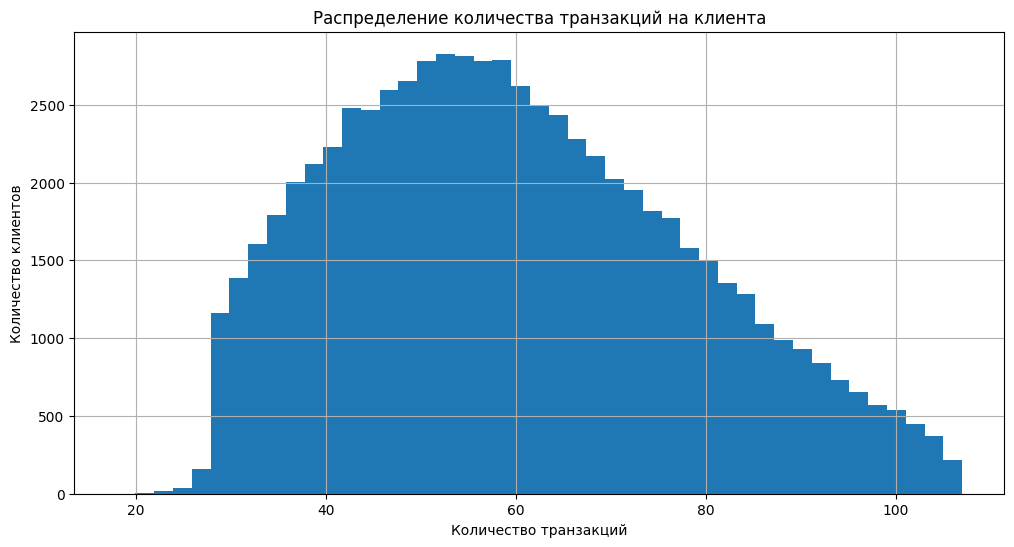

In [ ]:
# 2.2 customer_id (категориальная переменная)
print("\nАнализ столбца customer_id:")
print(f"Количество уникальных клиентов: {transactions['customer_id'].nunique()}")
plt.figure(figsize=(12, 6))
transactions['customer_id'].value_counts().hist(bins=45)
plt.title("Распределение количества транзакций на клиента")
plt.xlabel("Количество транзакций")
plt.ylabel("Количество клиентов")
plt.show()


Анализ столбца datetime_id:
datetime_id
3    1579903
2    1544148
1     891688
0     135357
Name: count, dtype: int64


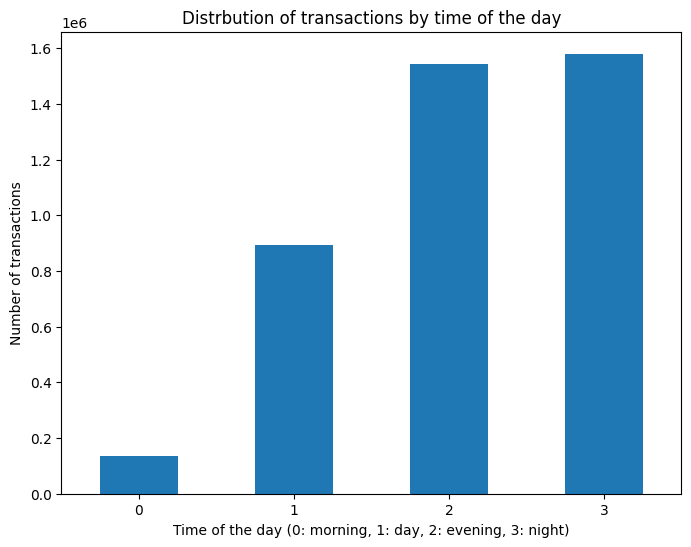

In [34]:
# 2.3 datetime_id (категориальная переменная, время суток)
print("\nАнализ столбца datetime_id:")
print(transactions['datetime_id'].value_counts())
plt.figure(figsize=(8, 6))
transactions['datetime_id'].value_counts().sort_index().plot(kind='bar') # sort_index чтобы утро-день-вечер-ночь шли по порядку
plt.title("Distrbution of transactions by time of the day")
plt.xlabel("Time of the day (0: morning, 1: day, 2: evening, 3: night)")
plt.ylabel("Number of transactions")
plt.xticks(rotation=0)
plt.show()


Анализ столбца count:
Количество нулевых значений: 0


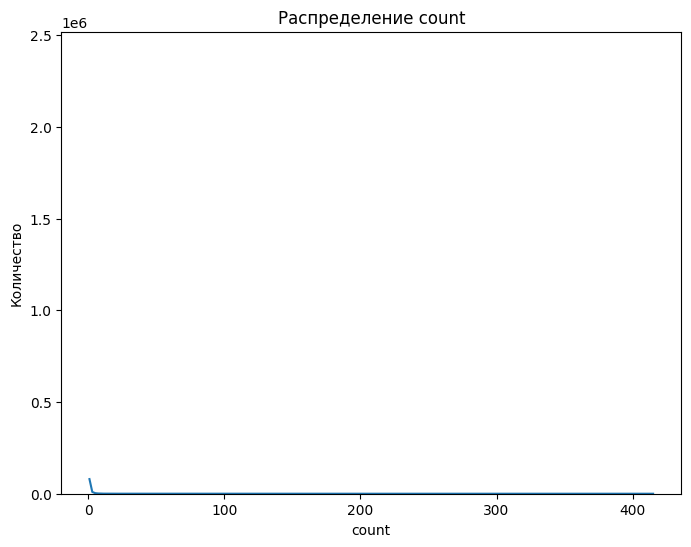

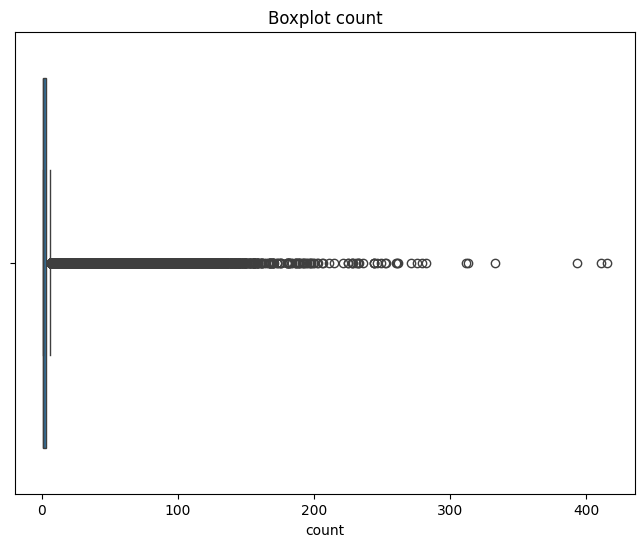

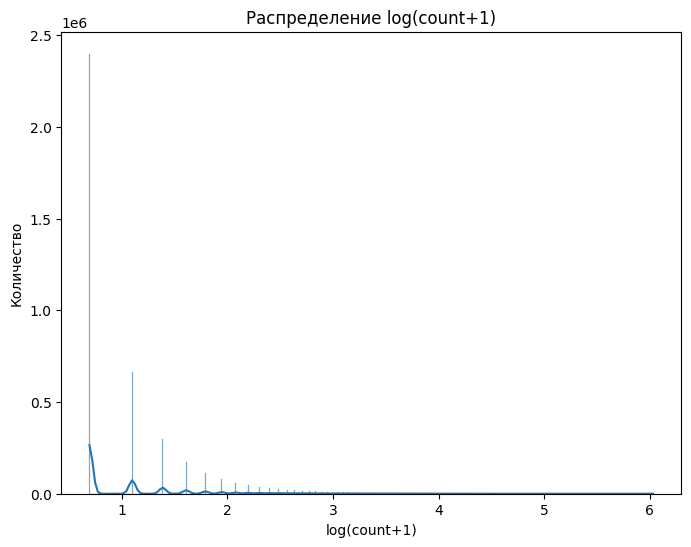


Анализ столбца sum:
Количество нулевых значений: 0


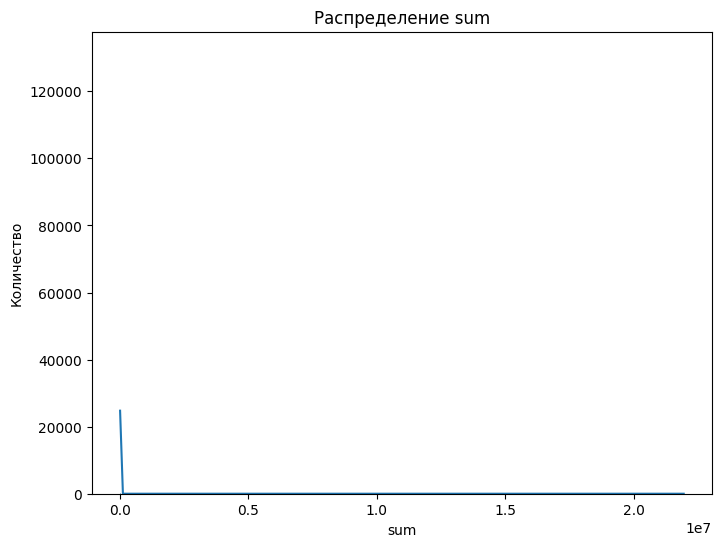

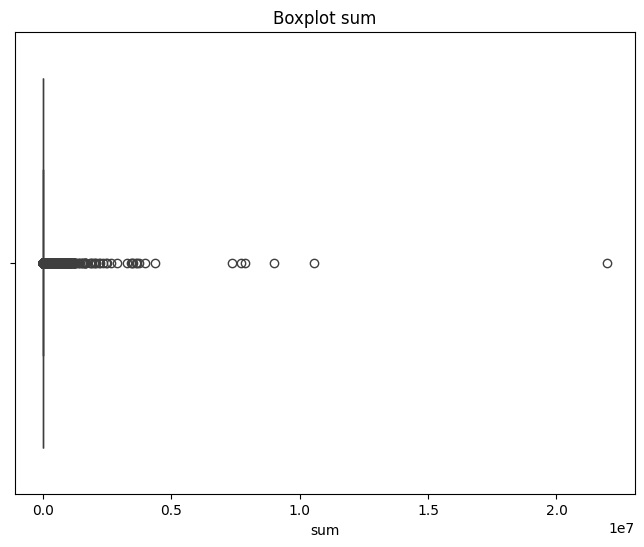

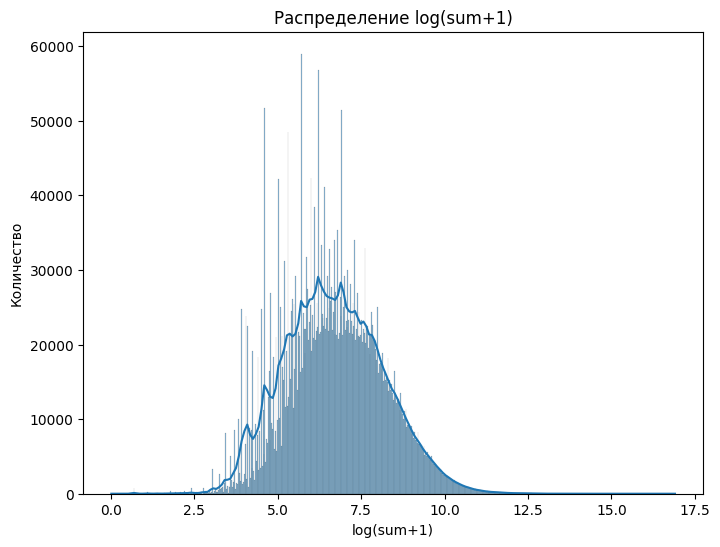


Анализ столбца avg:
Количество нулевых значений: 0


KeyboardInterrupt: 

: 

: 

Error in callback <function flush_figures at 0x7e2843bf0220> (for post_execute), with arguments args (),kwargs {}:



KeyboardInterrupt



In [ ]:
# 2.4 count, sum, avg, min, max, std (числовые переменные)
numeric_cols = ['count', 'sum', 'avg', 'min', 'max', 'std']

for col in numeric_cols:
    print(f"\nАнализ столбца {col}:")
    print(f"Количество нулевых значений: {(transactions[col] == 0).sum()}") # Анализ на нулевые значения
    if transactions[col].isnull().any(): # Проверка на NaN перед заполнением
        transactions[col] = transactions[col].fillna(0) # Заполнение NaN нулями (или другим подходящим значением)
    plt.figure(figsize=(8, 6))
    sns.histplot(transactions[col], kde=True) # используем seaborn для лучшего отображения kde
    plt.title(f"Распределение {col}")
    plt.xlabel(col)
    plt.ylabel("Количество")
    plt.show()

    # Boxplot для выявления выбросов
    plt.figure(figsize=(8, 6))
    sns.boxplot(x=transactions[col])
    plt.title(f"Boxplot {col}")
    plt.show()
    # Логарифмическое масштабирование (если есть большие выбросы)
    if (transactions[col] > 0).any():  # Проверяем, есть ли положительные значения перед логарифмированием
        plt.figure(figsize=(8, 6))
        sns.histplot(np.log1p(transactions[col]), kde=True)
        plt.title(f"Распределение log({col}+1)")
        plt.xlabel(f"log({col}+1)")
        plt.ylabel("Количество")
        plt.show()


Анализ столбца count_distinct:
count_distinct
1      3027881
2       585070
3       214437
4       103874
5        59592
        ...   
71           1
88           1
68           1
106          1
89           1
Name: count, Length: 82, dtype: int64


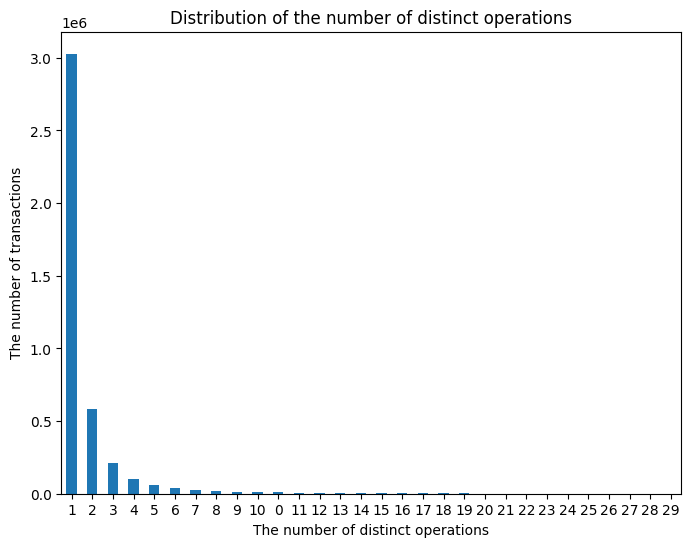

In [35]:
# 2.5 count_distinct (числовая переменная)
print("\nАнализ столбца count_distinct:")
print(transactions['count_distinct'].value_counts())

plt.figure(figsize=(8, 6))
transactions['count_distinct'].value_counts().head(30).plot(kind='bar')
plt.title("Distribution of the number of distinct operations")
plt.xlabel("The number of distinct operations")
plt.ylabel("The number of transactions")
plt.xticks(rotation=0)
plt.show()


Анализ столбца mcc_code:
mcc_code
13    1512867
8      912094
5      422039
9      284659
0      208830
6      178608
10     163521
11      95126
17      90401
12      49357
4       38132
18      38103
14      37212
3       33450
1       26964
20      22288
16      12599
22       6149
15       5952
2        4486
7        2969
21       2917
23       1257
19       1116
Name: count, dtype: int64


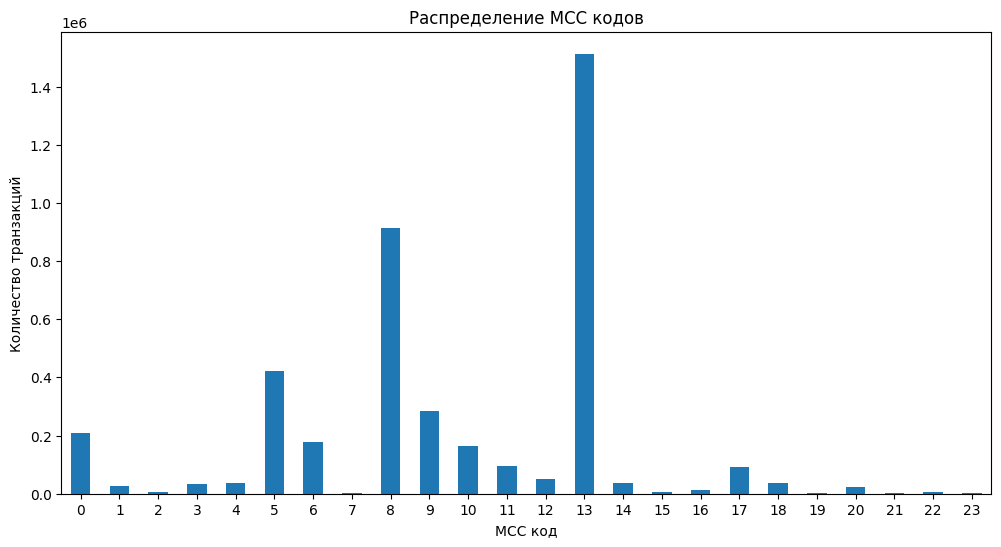

In [ ]:
# 2.6 mcc_code (категориальная переменная)
print("\nАнализ столбца mcc_code:")
print(transactions['mcc_code'].value_counts())

plt.figure(figsize=(12, 6))
transactions['mcc_code'].value_counts().sort_index().plot(kind='bar') # sort_index чтобы коды шли по порядку
plt.title("Распределение MCC кодов")
plt.xlabel("MCC код")
plt.ylabel("Количество транзакций")
plt.xticks(rotation=0) # оставляем как есть, их немного.
plt.show()


Анализ столбцов lat и lon:


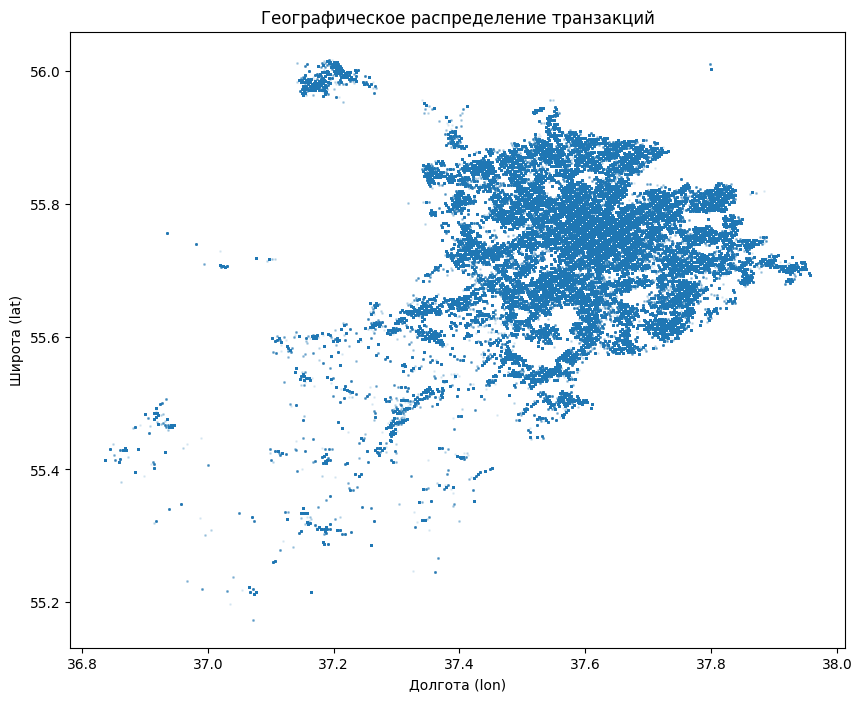

In [ ]:
#2.7 lat и lon
print("\nАнализ столбцов lat и lon:")
plt.figure(figsize=(10,8))
plt.scatter(transactions['lon'], transactions['lat'], s=1, alpha=0.1) # s - размер точки, alpha - прозрачность
plt.title("Географическое распределение транзакций")
plt.xlabel("Долгота (lon)")
plt.ylabel("Широта (lat)")
plt.show()

In [ ]:
import geopandas
import contextily as ctx


# Создание GeoDataFrame
gdf = geopandas.GeoDataFrame(
    transactions, geometry=geopandas.points_from_xy(transactions.lon, transactions.lat), crs="EPSG:4326"
)  # CRS - система координат (WGS 84)


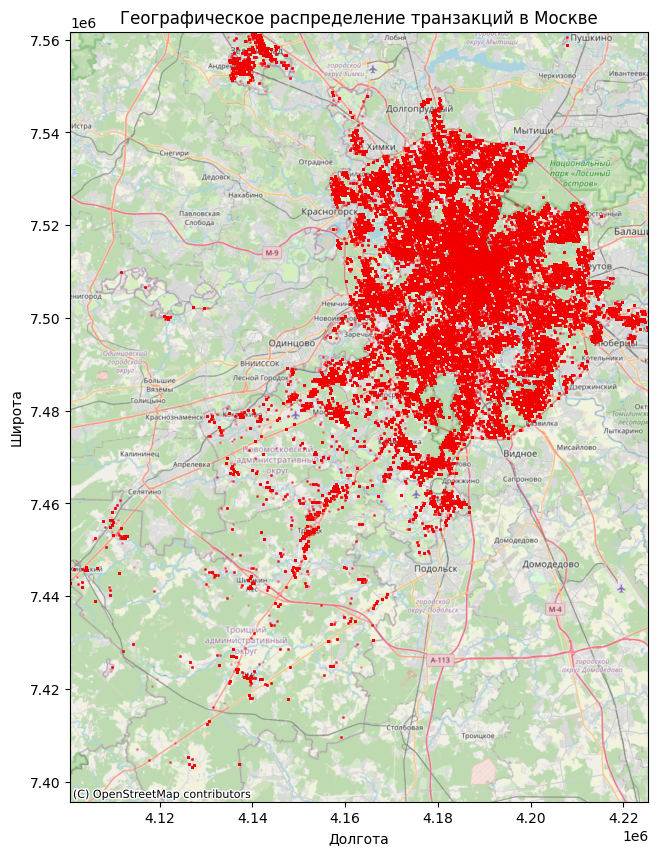

In [ ]:

# Преобразование в систему координат, подходящую для contextily (Mercator)
gdf = gdf.to_crs("EPSG:3857")

# Определение границ карты
min_lon, min_lat, max_lon, max_lat = gdf.geometry.total_bounds

# Построение графика
fig, ax = plt.subplots(figsize=(10, 10))
gdf.plot(ax=ax, markersize=1, color='red', alpha=0.1)

# Добавление базовой карты из contextily
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik, crs="EPSG:3857")  #Важно указать crs карты.

# Настройка отображения
ax.set_xlim(min_lon, max_lon)
ax.set_ylim(min_lat, max_lat)
ax.set_title("Географическое распределение транзакций в Москве")
ax.set_xlabel("Долгота")
ax.set_ylabel("Широта")

plt.show()

In [18]:
part_transactions_with_tags = transactions.iloc[:100].merge(moscow, how='inner', on='h3_09')

In [21]:
import pandas as pd
import folium

# Определение центра карты (Москва) -  можно скорректировать, если нужно
moscow_lat = 55.7558
moscow_lon = 37.6173

# Создание карты - zoom_start можно настроить
m = folium.Map(location=[moscow_lat, moscow_lon], zoom_start=10)

# Добавление линий для каждой пары точек
for index, row in part_transactions_with_tags.iterrows():
    # Создаем список координат для линии.  Каждая координата - это [широта, долгота].
    locations = [[row['lat_x'], row['lon_x']], [row['lat_y'], row['lon_y']]]

    # Создаем PolyLine.
    folium.PolyLine(
        locations=locations,  # Список координат
        color='blue',         # Цвет линии (можно настроить)
        weight=2.5,          # Толщина линии (можно настроить)
        opacity=0.7,         # Прозрачность линии (можно настроить)
        popup=f"От: ({row['lat_x']}, {row['lon_x']}) До: ({row['lat_y']}, {row['lon_y']})"  # Всплывающая подсказка (можно настроить)
    ).add_to(m)

    # Опционально: Добавляем маркеры для начальной и конечной точек (если нужно)
    folium.CircleMarker(location=[row['lat_x'], row['lon_x']], radius=3, color='green', fill=True, fill_color='green').add_to(m)
    folium.CircleMarker(location=[row['lat_y'], row['lon_y']], radius=3, color='red', fill=True, fill_color='red').add_to(m)

# Сохранение карты в HTML-файл
m.save("moscow_transactions_connections.html")

print("Карта сохранена в файл moscow_transactions_connections.html")

Карта сохранена в файл moscow_transactions_connections.html


In [ ]:
import pandas as pd
import folium
from folium.plugins import FastMarkerCluster


# Определение центра карты (Москва)
moscow_lat = 55.7558
moscow_lon = 37.6173

# Создание карты
m = folium.Map(location=[moscow_lat, moscow_lon], zoom_start=10)

# Создание списка координат
locations = transactions[['lat', 'lon']].values.tolist()

# Создание кластера маркеров
fast_marker_cluster = FastMarkerCluster(locations).add_to(m)

# Сохранение карты в HTML-файл
m.save("moscow_transactions_fast_clustered.html")

print("Карта сохранена в файл moscow_transactions_fast_clustered.html")

Карта сохранена в файл moscow_transactions_fast_clustered.html


In [ ]:
import pandas as pd
import folium
from folium.plugins import HeatMap


# Определение центра карты (Москва)
moscow_lat = 55.7558
moscow_lon = 37.6173

# Создание карты
m = folium.Map(location=[moscow_lat, moscow_lon], zoom_start=10)

# Создание списка координат
locations = transactions[['lat', 'lon']].values.tolist()

# Создание тепловой карты
HeatMap(locations).add_to(m)

# Сохранение карты в HTML-файл
m.save("moscow_transactions_heatmap.html")

print("Карта сохранена в файл moscow_transactions_heatmap.html")

Карта сохранена в файл moscow_transactions_heatmap.html


In [33]:
import h3

for index, row in hexses_data.iterrows():
    h3_index = row['h3_09']
    try:
        resolution = h3.get_resolution(h3_index)
        print(f"h3_index: {h3_index}, resolution: {resolution}")
    except ValueError:
        print(f"Invalid h3 index: {h3_index}")

# Сделай то же самое для hexses_target

h3_index: 89118180927ffff, resolution: 9
h3_index: 89118180d27ffff, resolution: 9
h3_index: 891181820abffff, resolution: 9
h3_index: 891181840a7ffff, resolution: 9
h3_index: 891181844c3ffff, resolution: 9
h3_index: 89118184c93ffff, resolution: 9
h3_index: 891181854b7ffff, resolution: 9
h3_index: 89118186067ffff, resolution: 9
h3_index: 8911818610bffff, resolution: 9
h3_index: 89118186173ffff, resolution: 9
h3_index: 8911818620bffff, resolution: 9
h3_index: 89118186227ffff, resolution: 9
h3_index: 89118186233ffff, resolution: 9
h3_index: 89118186343ffff, resolution: 9
h3_index: 89118186347ffff, resolution: 9
h3_index: 8911818635bffff, resolution: 9
h3_index: 89118186493ffff, resolution: 9
h3_index: 8911818654fffff, resolution: 9
h3_index: 89118186813ffff, resolution: 9
h3_index: 89118186817ffff, resolution: 9
h3_index: 89118186857ffff, resolution: 9
h3_index: 89118186883ffff, resolution: 9
h3_index: 89118186887ffff, resolution: 9
h3_index: 89118186897ffff, resolution: 9
h3_index: 891181

In [34]:
# Функция для отображения гексагона
def add_hex_to_map(m, h3_index, color, popup_text=""):
    """Добавляет гексагон на карту Folium.

    Args:
        m: Объект карты Folium.
        h3_index: H3 индекс гексагона (строка).
        color: Цвет гексагона (строка, например, 'red', 'blue', '#FF0000').
        popup_text: Текст для всплывающей подсказки (опционально).
    """
    try:
        geo_boundary = h3.cell_to_boundary(h3_index)
    except ValueError:
        print(f"Invalid h3 index: {h3_index}")
        return

    # Folium >= 0.14.0  уже ожидает (широта, долгота),
    # поэтому  НЕ НУЖНО менять порядок координат!
    # reversed_boundary = [[coord[1], coord[0]] for coord in geo_boundary] # УДАЛЯЕМ ЭТУ СТРОКУ

    folium.Polygon(
        locations=geo_boundary,  # Используем geo_boundary напрямую
        color=color,
        fill=True,
        fill_color=color,
        fill_opacity=0.4,
        popup=popup_text,
    ).add_to(m)


# Определение центра карты (можно вычислить среднее по всем lat/lon)
center_lat = (hexses_data['lat'].mean() + hexses_target['lat'].mean()) / 2
center_lon = (hexses_data['lon'].mean() + hexses_target['lon'].mean()) / 2

# Создание карты
m = folium.Map(location=[center_lat, center_lon], zoom_start=8)  # Подберите zoom_start

# Добавление гексагонов из hexses_data (красным цветом)
for index, row in hexses_data.iterrows():
    add_hex_to_map(m, row['h3_09'], 'red', popup_text=f"hexses_data: {row['h3_09']}")

# Добавление гексагонов из hexses_target (синим цветом)
for index, row in hexses_target.iterrows():
    add_hex_to_map(m, row['h3_09'], 'blue', popup_text=f"hexses_target: {row['h3_09']}")

# Опционально: добавление маркеров (кружков) для центров гексагонов
for index, row in hexses_data.iterrows():
    folium.CircleMarker(location=[row['lat'], row['lon']], radius=4, color='darkred', fill=True, fill_color='darkred').add_to(m)
for index, row in hexses_target.iterrows():
    folium.CircleMarker(location=[row['lat'], row['lon']], radius=4, color='darkblue', fill=True, fill_color='darkblue').add_to(m)

# Сохранение карты
m.save("hexses_map.html")
print("Карта сохранена в файл hexses_map.html")

Карта сохранена в файл hexses_map.html


In [37]:
import pandas as pd
import folium


# Определение центра карты (можно вычислить среднее по всем lat/lon)
center_lat = (hexses_data['lat'].mean() + hexses_target['lat'].mean()) / 2
center_lon = (hexses_data['lon'].mean() + hexses_target['lon'].mean()) / 2

# Создание карты
m = folium.Map(location=[center_lat, center_lon], zoom_start=12)  # Начни с 12, потом подбери

# Добавление точек из hexses_data (красным цветом)
for index, row in hexses_data.iterrows():
    folium.CircleMarker(
        location=[row['lat'], row['lon']],
        radius=5,  # Размер маркера
        color='red',  # Цвет маркера
        fill=True,
        fill_color='red',
        fill_opacity=0.7,
        popup=f"hexses_data: lat={row['lat']:.4f}, lon={row['lon']:.4f}",  # Всплывающая подсказка
    ).add_to(m)

# Добавление точек из hexses_target (синим цветом)
for index, row in hexses_target.iterrows():
    folium.CircleMarker(
        location=[row['lat'], row['lon']],
        radius=5,
        color='blue',
        fill=True,
        fill_color='blue',
        fill_opacity=0.7,
        popup=f"hexses_target: lat={row['lat']:.4f}, lon={row['lon']:.4f}",
    ).add_to(m)

# Сохранение карты
m.save("lat_lon_map.html")
print("Карта сохранена в файл lat_lon_map.html")

Карта сохранена в файл lat_lon_map.html



Корреляционная матрица:


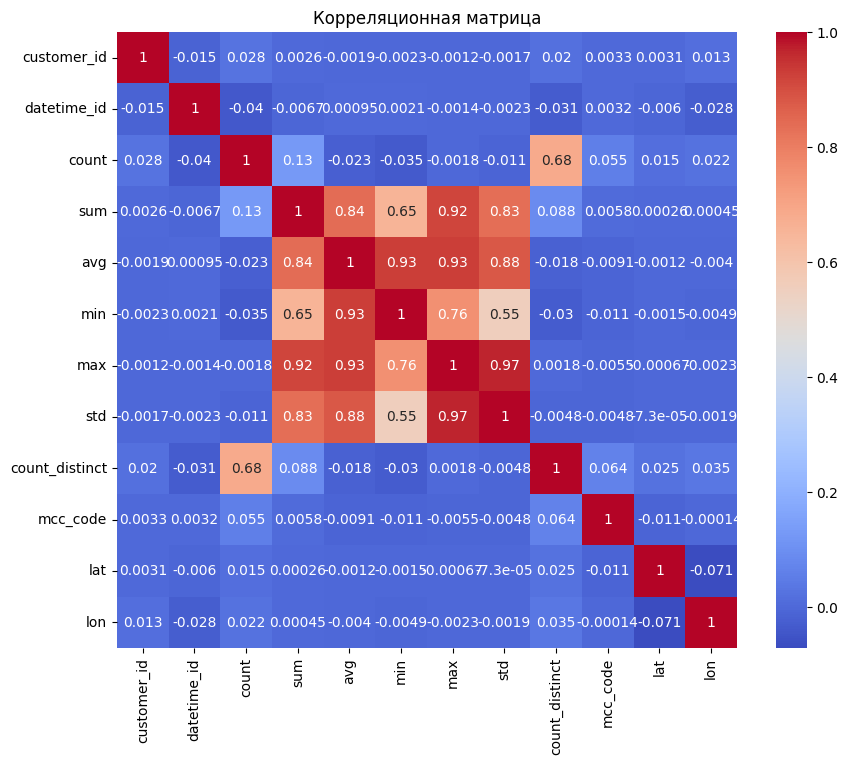

In [ ]:
# --- 3. Анализ взаимосвязей между столбцами ---

# 3.1 Корреляционная матрица (только для числовых столбцов)
print("\nКорреляционная матрица:")
numeric_df = transactions.select_dtypes(include=np.number)  #Выбираем только числовые столбцы для корреляции
corr_matrix = numeric_df.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm")
plt.title("Корреляционная матрица")
plt.show()

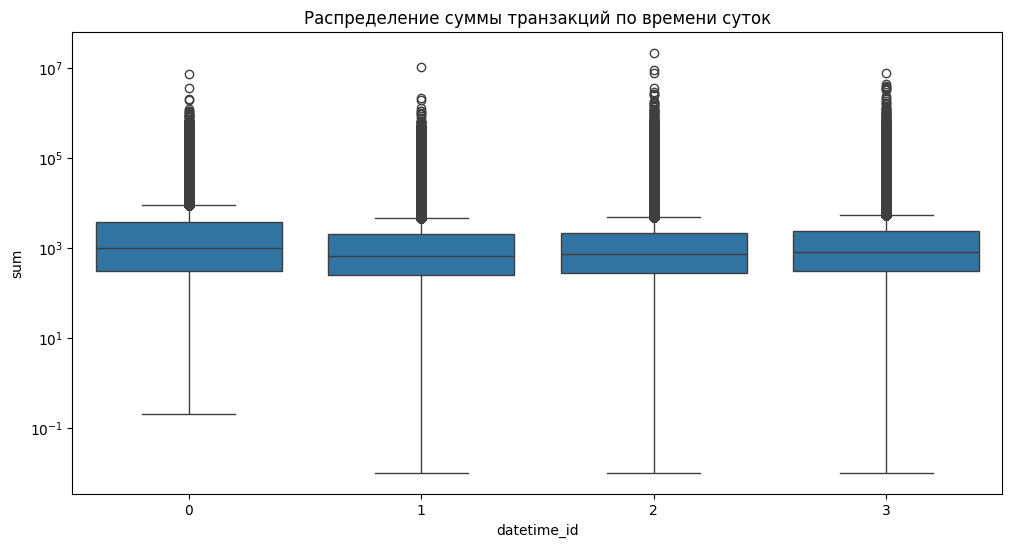

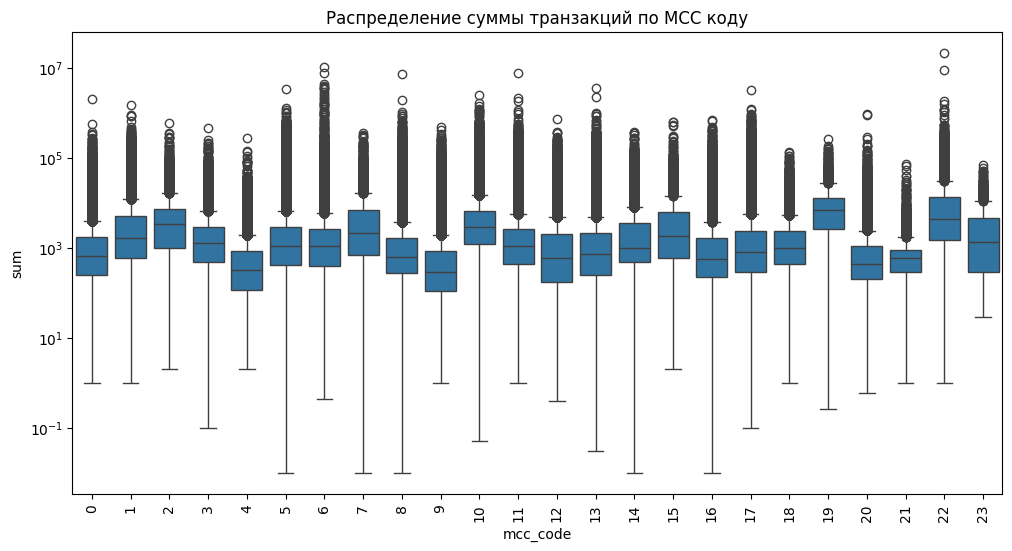

In [ ]:
# 3.3 Анализ `sum` в зависимости от других столбцов
plt.figure(figsize=(12, 6))
sns.boxplot(x='datetime_id', y='sum', data=transactions)
plt.title('Распределение суммы транзакций по времени суток')
plt.yscale('log')
plt.show()

plt.figure(figsize=(12, 6))
sns.boxplot(x='mcc_code', y='sum', data=transactions)
plt.title('Распределение суммы транзакций по MCC коду')
plt.xticks(rotation=90)
plt.yscale('log')
plt.show()

In [ ]:
# --- 4. Группировки ---

# 4.1 Группировка по клиенту
print("\nГруппировка по клиенту:")
customer_summary = transactions.groupby('customer_id').agg({
    'count': 'sum', # Общее количество транзакций
    'sum': 'sum',   # Общая сумма транзакций
    'h3_09': 'nunique', # Количество уникальных локаций
    'mcc_code': 'nunique' # Количество уникальных типов операций
})
customer_summary.head()


Группировка по клиенту:


,count,sum,h3_09,mcc_code
customer_id,,,,
1,149,134868.14,45,11
4,563,117952.36,32,10
5,139,156957.86,40,14
9,231,76170.44,16,4
11,184,550509.20,27,11


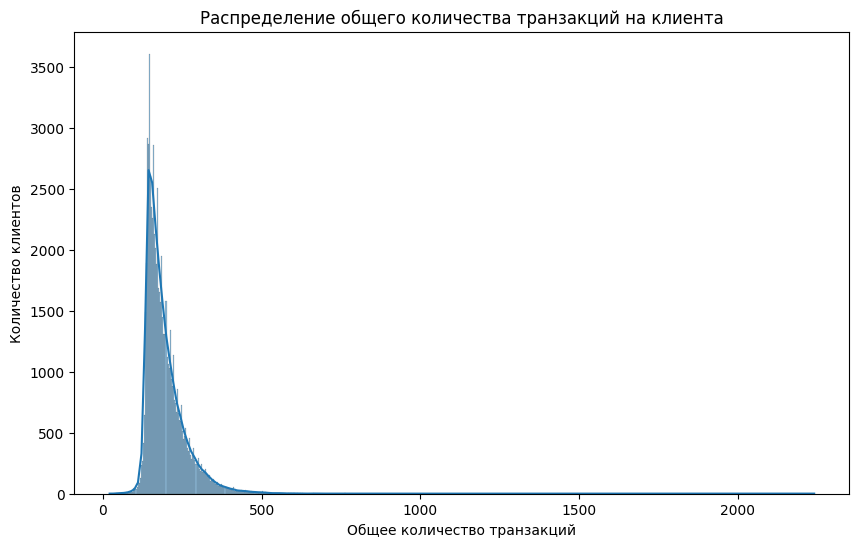

In [ ]:
# Визуализация
plt.figure(figsize=(10, 6))
sns.histplot(customer_summary['count'], kde=True)
plt.title("Распределение общего количества транзакций на клиента")
plt.xlabel("Общее количество транзакций")
plt.ylabel("Количество клиентов")
plt.show()

In [ ]:
# 4.2 Группировка по локации
print("\nГруппировка по локации:")
location_summary = transactions.groupby('h3_09').agg({
    'count': 'sum',
    'sum': 'sum',
    'customer_id': 'nunique'
})
location_summary.head()


Группировка по локации:


,count,sum,customer_id
h3_09,,,
89118180927ffff,22,18379.83,10
89118180d27ffff,1,790.00,1
891181820abffff,499,834526.82,248
891181840a7ffff,3,12377.50,3
891181844c3ffff,1,246.00,1


In [ ]:
import geopandas
from shapely.geometry import Point

In [ ]:
# --- 2. Преобразование в GeoDataFrames ---

# 2.1 Транзакции (transactions)
transactions = transactions.iloc[:10000]
geometry_transactions = [Point(xy) for xy in zip(transactions['lon'], transactions['lat'])]
gdf_transactions = geopandas.GeoDataFrame(transactions, geometry=geometry_transactions, crs="EPSG:4326")

geometry_hexses_target = [Point(xy) for xy in zip(hexses_target['lon'], hexses_target['lat'])]
gdf_hexses_target = geopandas.GeoDataFrame(hexses_target, geometry=geometry_hexses_target, crs="EPSG:4326")

geometry_hexses_data = [Point(xy) for xy in zip(hexses_data['lon'], hexses_data['lat'])]
gdf_hexses_data = geopandas.GeoDataFrame(hexses_data, geometry=geometry_hexses_data, crs="EPSG:4326")

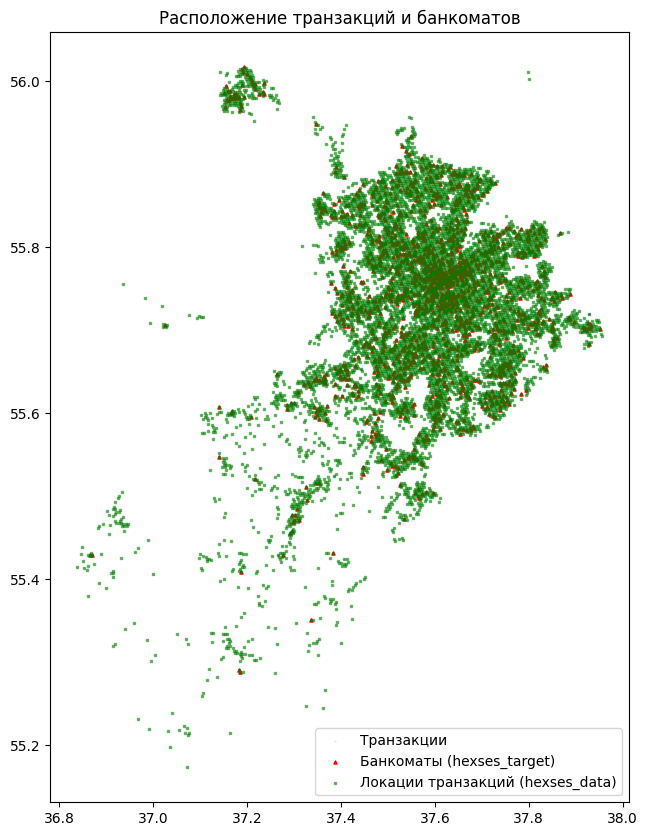

In [ ]:
# --- 3. Геоанализ ---

# 3.1 Визуализация: расположение транзакций и банкоматов
fig, ax = plt.subplots(figsize=(12, 10))
gdf_transactions.plot(ax=ax, markersize=1, color='blue', alpha=0.05, label='Транзакции')
gdf_hexses_target.plot(ax=ax, markersize=5, color='red', marker='^', label='Банкоматы (hexses_target)') # Треугольники
gdf_hexses_data.plot(ax=ax, markersize=3, color='green', marker='s', alpha = 0.5, label='Локации транзакций (hexses_data)') # Квадраты
ax.set_title("Расположение транзакций и банкоматов")
ax.legend()
plt.show()

In [ ]:
# 3.2 Пространственное соединение (Spatial Join):  Какие банкоматы находятся рядом с транзакциями клиентов?
# Этот анализ может помочь понять, какие банкоматы наиболее востребованы.
transactions_within_500m = geopandas.sjoin(gdf_hexses_target, gdf_transactions, how="inner", predicate="within") # op='within' или 'intersects'
print("\nКоличество транзакций в радиусе 500м от банкоматов:", len(transactions_within_500m)) # Больше транзакций - популярнее банкомат
# Посчитать сколько уникальных клиентов совершали операции около каждого банкомата
transactions_per_atm = transactions_within_500m.groupby('h3_09_left')['customer_id'].nunique().sort_values(ascending=False)
print("\nКоличество уникальных клиентов, совершавших операции около каждого банкомата (ТОП-10):\n", transactions_per_atm.head(10))


Количество транзакций в радиусе 500м от банкоматов: 6761

Количество уникальных клиентов, совершавших операции около каждого банкомата (ТОП-10):
 h3_09_left
8911aa7abd3ffff    1686
8911aa68e7bffff     712
8911aa7a967ffff     337
8911aa7a107ffff      57
8911aa7a117ffff      53
8911aa6360bffff      43
891181b6507ffff      38
8911aa7103bffff      33
8911aa7a103ffff      29
8911aa78dc7ffff      28
Name: customer_id, dtype: int64


In [ ]:
# --- 4. Дальнейшие направления для геоанализа (с учетом бизнес-правил) ---

# 4.1 Расстояние от дома/работы до банкомата:
#    * Предполагаем, что транзакции чаще всего совершаются рядом с домом или работой клиента.
#    * Вычисляем расстояние между локациями транзакций клиента (из transactions) и ближайшими банкоматами (из hexses_target).
#    * Создаем признак: "среднее расстояние до ближайшего банкомата".
#    * Это может помочь предсказать, какие банкоматы клиент с большей вероятностью будет использовать.

# 4.2 Плотность банкоматов в районе:
#    * Вычисляем плотность банкоматов в разных районах города (используя h3_09).
#    * Предполагаем, что в районах с высокой плотностью банкоматов клиенты имеют больший выбор и могут предпочитать определенные банкоматы.
#    * Создаем признак: "плотность банкоматов в районе".

# 4.3 Привязка к POI (Points of Interest):
#    * Используем данные OpenStreetMap (moscow.parquet) для определения POI (магазины, кафе, остановки общественного транспорта) рядом с банкоматами.
#    * Предполагаем, что банкоматы, расположенные рядом с POI, более посещаемы.
#    * Создаем признаки: "количество POI в радиусе X метров от банкомата", "тип ближайшего POI".

# 4.4 Использование H3 для агрегации и анализа:
#    * Агрегируем данные о транзакциях и банкоматах на более высоких уровнях H3 (например, h3_08, h3_07).
#    * Это позволит выявить общие закономерности на уровне районов города.

# 4.5 Анализ "мобильности" клиентов:
#    * Для каждого клиента определяем набор уникальных h3_09 локаций, где он совершал транзакции.
#    * Вычисляем "радиус" этой области (максимальное расстояние между локациями).
#    * Это может помочь понять, насколько "мобилен" клиент, и какие банкоматы находятся в пределах его обычной географической области.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4151096 entries, 0 to 4151095
Data columns (total 13 columns):
 #   Column          Dtype  
---  ------          -----  
 0   h3_09           object 
 1   customer_id     int64  
 2   datetime_id     int64  
 3   count           int64  
 4   sum             float64
 5   avg             float64
 6   min             float64
 7   max             float64
 8   std             float64
 9   count_distinct  int64  
 10  mcc_code        int64  
 11  lat             float64
 12  lon             float64
dtypes: float64(7), int64(5), object(1)
memory usage: 411.7+ MB


In [ ]:
projected_crs = "EPSG:32637"

# --- 4.1 Расстояние от дома/работы до банкомата:

# 4.1.0 Перепроецируем GeoDataFrames в проекционную систему координат
gdf_transactions_proj = gdf_transactions.to_crs(projected_crs)
gdf_hexses_target_proj = gdf_hexses_target.to_crs(projected_crs)

# Функция для вычисления расстояния между двумя GeoSeries (в метрах)
def calculate_distance(point1, point2):
    return point1.distance(point2)

# 4.1.1 Для каждой транзакции находим ближайший банкомат
gdf_transactions_proj['nearest_atm_distance'] = gdf_transactions_proj.apply(
    lambda row: gdf_hexses_target_proj.geometry.distance(row['geometry']).min(), axis=1
)

# 4.1.2 Вычисляем среднее расстояние до ближайшего банкомата для каждого клиента
avg_distance_to_atm = gdf_transactions_proj.groupby('customer_id')['nearest_atm_distance'].mean().reset_index()
avg_distance_to_atm.rename(columns={'nearest_atm_distance': 'avg_distance_to_nearest_atm'}, inplace=True)
print("\nСреднее расстояние до ближайшего банкомата для каждого клиента (ТОП-10):\n", avg_distance_to_atm.head(10))


Среднее расстояние до ближайшего банкомата для каждого клиента (ТОП-10):
    customer_id  avg_distance_to_nearest_atm
0            1                   589.753885
1            4                     0.000000
2            5                     0.000000
3            9                   324.185230
4           11                     0.000000
5           12                     0.000000
6           13                   577.249557
7           15                   572.164544
8           16                     0.000000
9           17                   324.898213


In [ ]:
# 4.2 Плотность банкоматов в районе:

# 4.2.1 Создаем колонку с h3_08 (более крупная ячейка)
gdf_hexses_target['h3_08'] = gdf_hexses_target['h3_09'].apply(lambda x: h3.cell_to_parent(x, 8))

# 4.2.2 Считаем количество банкоматов в каждой h3_08 ячейке
atm_density = gdf_hexses_target['h3_08'].value_counts().reset_index()
atm_density.columns = ['h3_08', 'atm_count']
print("\nПлотность банкоматов в районе (h3_08) (ТОП-10):\n", atm_density.head(10))

# 4.2.3 Присоединяем плотность банкоматов к транзакциям (по h3_08)
gdf_transactions['h3_08'] = gdf_transactions['h3_09'].apply(lambda x: h3.cell_to_parent(x, 8))
gdf_transactions = gdf_transactions.merge(atm_density, on='h3_08', how='left')
gdf_transactions['atm_count'] = gdf_transactions['atm_count'].fillna(0) # Заполняем NaN нулями (если нет банкоматов в районе)
print("\nПример данных с плотностью банкоматов:\n", gdf_transactions[['h3_09', 'h3_08', 'atm_count']].head())



Плотность банкоматов в районе (h3_08) (ТОП-10):
              h3_08  atm_count
0  8811aa7ab9fffff          7
1  8811aa6365fffff          7
2  8811aa7ad5fffff          6
3  8811aa7a8bfffff          6
4  8811aa7a87fffff          6
5  8811aa7a83fffff          6
6  8811aa7ab1fffff          6
7  8811aa7abdfffff          6
8  8811aa7ab3fffff          6
9  8811aa7ae3fffff          5

Пример данных с плотностью банкоматов:
              h3_09            h3_08  atm_count
0  8911aa4c62fffff  8811aa4c63fffff        0.0
1  8911aa7b5b3ffff  8811aa7b5bfffff        2.0
2  8911aa63623ffff  8811aa6363fffff        4.0
3  8911aa48577ffff  8811aa4857fffff        2.0
4  8911aa78297ffff  8811aa7829fffff        1.0


In [ ]:
# 4.3 Привязка к POI (Points of Interest):


# 4.3.1 Преобразуем moscow в GeoDataFrame
geometry_osm = [Point(xy) for xy in zip(moscow['lon'], moscow['lat'])]
gdf_osm = geopandas.GeoDataFrame(moscow, geometry=geometry_osm, crs="EPSG:4326")

# 4.3.2 Определяем радиус поиска POI (в метрах)
poi_radius = 200  # Например, 200 метров

# 4.3.3 Функция для подсчета POI в радиусе от банкомата
def count_poi_in_radius(atm_point):
    # Создаем буфер вокруг банкомата
    buffer = atm_point.buffer(poi_radius / 111111)  # 1 градус ~ 111111 метров
    # Находим POI, которые пересекают буфер
    poi_within_radius = gdf_osm[gdf_osm.intersects(buffer)]
    # Возвращаем количество POI
    return len(poi_within_radius)

In [ ]:
gdf_hexses_target = gdf_hexses_target.iloc[:1000]

In [ ]:
# 4.3.4 Применяем функцию к банкоматам
gdf_hexses_target['poi_count'] = gdf_hexses_target['geometry'].apply(count_poi_in_radius)
print("\nКоличество POI в радиусе от банкомата (ТОП-10):\n", gdf_hexses_target[['h3_09', 'poi_count']].head(10))

KeyboardInterrupt: 

In [ ]:

# 4.3.5 Тип ближайшего POI (пример)
# Эту часть можно расширить, чтобы учитывать разные типы POI (магазины, кафе и т.д.)


# 4.4 Использование H3 для агрегации и анализа:

# 4.4.1 Уже создали h3_08 для плотности банкоматов
# Можно агрегировать другие признаки на уровне h3_08 или h3_07

# 4.4.2 Пример: средняя сумма транзакций на уровне h3_08
avg_sum_h3_08 = gdf_transactions.groupby('h3_08')['sum'].mean().reset_index()
avg_sum_h3_08.columns = ['h3_08', 'avg_sum']
print("\nСредняя сумма транзакций на уровне h3_08 (ТОП-10):\n", avg_sum_h3_08.head(10))


Средняя сумма транзакций на уровне h3_08 (ТОП-10):
              h3_08  avg_sum
0  8811818611fffff  2528.08
1  8811818681fffff   536.00
2  88118190a9fffff   383.00
3  881181940bfffff  1451.26
4  8811819513fffff  3150.00
5  8811819589fffff    98.00
6  88118195c3fffff   580.00
7  88118195c9fffff  3658.51
8  881181b281fffff    85.00
9  881181b283fffff   405.00


In [ ]:
# 4.4.3 Присоединяем к транзакциям
gdf_transactions = gdf_transactions.merge(avg_sum_h3_08, on='h3_08', how='left')

In [ ]:
# 4.5 Анализ "мобильности" клиентов:

# 4.5.1 Функция для вычисления радиуса области транзакций клиента
def calculate_mobility_radius(customer_id, gdf):
    customer_locations = gdf[gdf['customer_id'] == customer_id]['geometry']
    if len(customer_locations) < 2:
        return 0  # Если у клиента меньше 2 транзакций, радиус = 0

    # Вычисляем центроид всех транзакций
    centroid = customer_locations.union_all().centroid

    # Вычисляем максимальное расстояние от центроида до любой точки транзакции
    max_distance = max([centroid.distance(point) for point in customer_locations])

    return max_distance


# 4.5.2 Применяем функцию к каждому клиенту
unique_customer_ids = gdf_transactions['customer_id'].unique() # Берем уникальные ID клиентов
mobility_radius = {}
for customer_id in unique_customer_ids:
    mobility_radius[customer_id] = calculate_mobility_radius(customer_id, gdf_transactions)

In [ ]:






# 4.5 Анализ "мобильности" клиентов:

# 4.5.1 Функция для вычисления радиуса области транзакций клиента
def calculate_mobility_radius(customer_id, gdf):
    customer_locations = gdf[gdf['customer_id'] == customer_id]['geometry']
    if len(customer_locations) < 2:
        return 0  # Если у клиента меньше 2 транзакций, радиус = 0

    # Вычисляем центроид всех транзакций
    centroid = customer_locations.unary_union.centroid

    # Вычисляем максимальное расстояние от центроида до любой точки транзакции
    max_distance = max([centroid.distance(point) for point in customer_locations])

    return max_distance


# 4.5.2 Применяем функцию к каждому клиенту
unique_customer_ids = gdf_transactions['customer_id'].unique() # Берем уникальные ID клиентов
mobility_radius = {}
for customer_id in unique_customer_ids:
    mobility_radius[customer_id] = calculate_mobility_radius(customer_id, gdf_transactions)

mobility_radius_df = pd.DataFrame.from_dict(mobility_radius, orient='index', columns=['mobility_radius'])
mobility_radius_df.index.name = 'customer_id' # Важно задать имя индексу
mobility_radius_df = mobility_radius_df.reset_index() # Преобразуем индекс в столбец

print("\nРадиус мобильности клиентов (ТОП-10):\n", mobility_radius_df.head(10))

# 4.5.3 Присоединяем радиус мобильности к транзакциям
gdf_transactions = gdf_transactions.merge(mobility_radius_df, on='customer_id', how='left')


print("\nГеоанализ завершен.  Созданы новые признаки в gdf_transactions и gdf_hexses_target.")
print("\nПример данных gdf_transactions:\n", gdf_transactions.head())


Радиус мобильности клиентов (ТОП-10):
    customer_id  mobility_radius
0            1         0.143052
1            4         0.063229
2            5         0.000000
3            9         0.000000
4           11         0.000000
5           12         0.000000
6           13         0.000000
7           15         0.000000
8           16         0.000000
9           17         0.000000

Геоанализ завершен.  Созданы новые признаки в gdf_transactions и gdf_hexses_target.

Пример данных gdf_transactions:
              h3_09  customer_id  datetime_id  count       sum       avg  \
0  8911aa4c62fffff            1            3      1   3346.65  3346.650   
1  8911aa7b5b3ffff            4            3      1    450.00   450.000   
2  8911aa63623ffff            5            3     10  11035.69  1103.569   
3  8911aa48577ffff            9            2      2    628.00   314.000   
4  8911aa78297ffff           11            2      1   4155.00  4155.000   

       min      max          std  coun

In [ ]:
strs = ["cir","car"]
lens = [len(s) for s in strs]
idx = min(range(len(lens)), key=lens.__getitem__)
smallest_str = strs[idx]
strs.remove(strs[idx])
idx

0

In [ ]:
substr = ''
subletter_prev = -1
for s in smallest_str:
    print(strs)
    print('letter: ', s)
    for i in strs:
        
        subletter = i.find(s)
        if (subletter==-1) and (subletter_prev != -1)\
            or (subletter!=-1) and substr != '':
            break
        subletter_prev = subletter
        print(subletter)
        
    if subletter != -1:
        print("if: ", s)
        substr += s
substr

['car']
letter:  c
0
if:  c
['car']
letter:  i
['car']
letter:  r
if:  r


'cr'